# Summary

The foul ball formula seems to be:
```python
foul_threshold = 0.25 + 0.1*fwd - 0.1*obt + 0.1*batter_vibes*((musc + thwack + div)/3 + 0.2*hypediff)
```
(musc, thwack, div are not already vibed in here)

Rolls below this threshold are fouls, rolls above it are fair. Astrid figured this out last week, but I want to show it in a notebook to make it easier to find.
I have succeeded! It seems that this formula is correct.

Oddities in this formula:

- ~~Traveling applies something like a 3.5% boost, not the 5% advertised~~ I think this is just because it skips thwack?
- ~~Growth applies something like a 0-3.5% boost, not the 0-5% boost advertised~~ I think this is just because it skips thwack?
- Night Vision Goggles are real! Not applying that boost causes an outlier here. It's kind of annoying to apply though since it's not a modification, but instead a DE-era item.

Also, the attribute-specific boosts of Chunky and Smooth matter here, and it seems that they aren't necessarily a flat 100% to every affected attribute. Using 15% for the musclitude boost of Smooth made it work here. Worked out 15% via this:

Spin Attack ("+15% speed" blessing) results:
```
Hewitt Best:
musc:  0.7458 to 0.7683 : 0.0225
cont:  1.098  to 1.173  : 0.075
gf:    0.378  to 0.453  : 0.075
laser: 1.06   to 1.18   : 0.12
```

Ooze, in the same election, boosted "power" by "10%". according to Thomas Dracaena's history, it boosted:
```
div:  0.10
musc: 0.10
gf:   0.05
```
So div and musc would be actually +100% for Chunky, if this ratio holds (and indeed using that worked for me here).


## Load data

In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm

import load

In [2]:
season = 18
df = load.data("fouls", season=None)

df["musc_vibes"] = load.player_attribute(df, 'batter', 'musclitude', vibes=True, mods=True, items=True, broken_items=True)
df["thwack_vibes"] = load.player_attribute(df, 'batter', 'thwackability', vibes=True, mods=True, items=True, broken_items=True)
df["div_vibes"] = load.player_attribute(df, 'batter', 'divinity', vibes=True, mods=True, items=True, broken_items=True)

# center=True is the default
df["forwardness"] = load.stadium_attribute(df, 'forwardness', center=False)
df["obtuseness"] = load.stadium_attribute(df, 'obtuseness', center=False)

df.groupby("season").size()

/Users/robbyblum/Downloads/sigh/resim/notebooks/load.py:153: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(f, dtype={"stadium_id": "string"}) for f in all_files), ignore_index=True)


season
11    58498
12    95588
13    92218
14    84485
15    83220
16    64988
17    13056
18    78244
dtype: int64

In [3]:
df["batter_attrs"] = (df["musc_vibes"] + df["thwack_vibes"] + df["div_vibes"]) / 3

df["hypediff_vibes"] = (df["batting_team_hype"] - df["pitching_team_hype"]) * (1 + 0.2 * df["batter_vibes"])

# put in our "best fit" up here in the original df, just because
df["threshold_best"] = (0.25
                        + 0.10 * df['forwardness'] 
                        - 0.10 * df['obtuseness'] 
                        + 0.10 * (df["musc_vibes"] + df["thwack_vibes"] + df["div_vibes"]) / 3
                       )

## Exclude data
For instance, can exclude specific mods, or situations with multipliers != 1.0. Here, I'm going to be excluding batters with O No, because that creates tons of foul balls that "shouldn't be" foul balls.

I'm also excluding LATE_TO_PARTY because it's a weird huge mess that I don't understand yet!

In [4]:
dfc = df.copy()
# dfc = dfc[~dfc["passed"].isna()]
# Sorry, Chorby Short
for exclude_mod in ["O_NO", "LATE_TO_PARTY"]:#, "TRAVELING"]:
# for exclude_mod in ["O_NO", "ON_FIRE", "SLOW_BUILD", "TRAVELING", "CHUNKY", "SMOOTH", "LATE_TO_PARTY",
#                    "GROWTH", "SINKING_SHIP", "TRAVELING"]:
# for exclude_mod in ["O_NO", "ON_FIRE", "PSYCHIC", "PARASITE", "MINIMALIST", "MAXIMALIST", "CHUNKY", "SMOOTH", "LATE_TO_PARTY",
#                     "OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
    # dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    # dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

# dfc = dfc[(dfc['pitcher_mul'] == 1) & (dfc['batter_mul'] == 1)]



In [5]:
# there are so many columns now, alas
# print(list(df.columns))
print(len(df))
print(len(dfc))
# dfc.head()

570297
523345


In [6]:
# preparing a useful digest list of columns for later
digest_list = [
    "event_type",
    "passed",
    "roll",
    "threshold",
    "offset",
    # "threshold_best",
    "batter_name",
    # "pitcher_name",
    "div_vibes",
    "musc_vibes",
    "thwack_vibes",
    "forwardness",
    "obtuseness",
    "game_id",
    "play_count",
    "batter_mods",
    "batting_team_mods",
    # "pitcher_mods",
    # "pitching_team_mods",
    "weather",
    "hypediff_vibes",
    "day",
]


### Preliminary plot

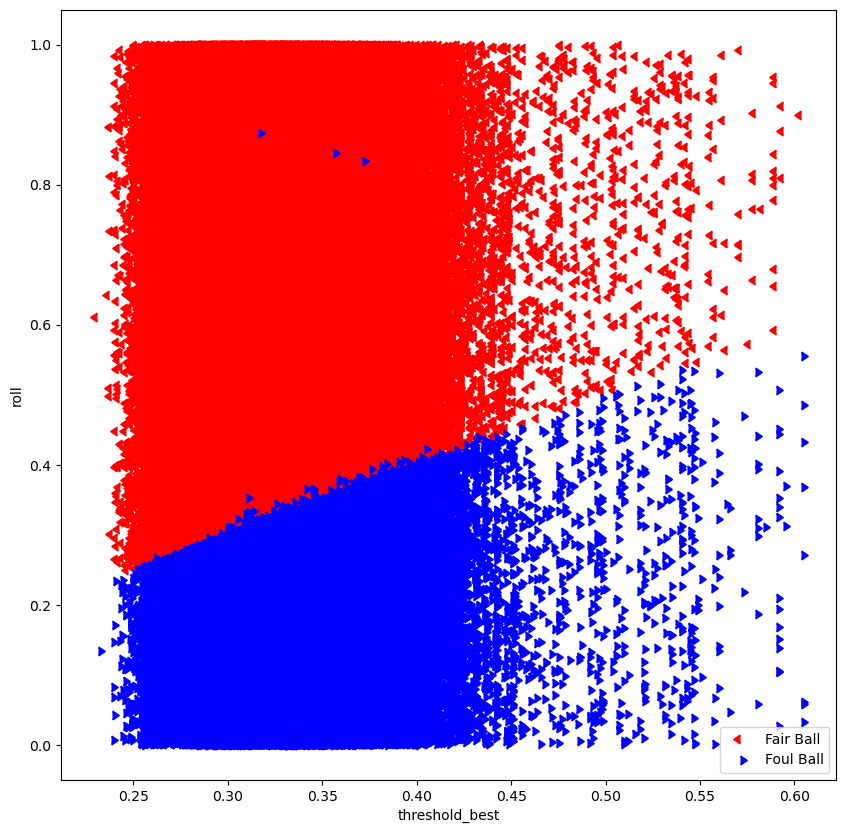

In [8]:
x_val = "musc_vibes"
x_val = "threshold_best"
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.scatter(
    dfc[~dfc["passed"].astype("bool")][x_val],
    dfc[~dfc["passed"].astype("bool")]["roll"],
    color="red",
    label="Fair Ball",
    marker=CARETLEFTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Foul Ball",
    marker=CARETRIGHTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
# ax.set_xlim(0.484, 0.499)

ax.legend()

# fig.savefig("../figures/" + x_val + ".png", facecolor="white")

## SVC fit

In [9]:
# The "include "passed" in X and then drop it" stuff is useful if you need to exclude a range of rolls,
# say because there's a max value for the threshold (like in the strike zone formula).
X = dfc[[
    "passed",
    "roll",
    # "div_vibes",
    # "musc_vibes",
    # "thwack_vibes",
    "batter_attrs",
    "forwardness",
    "obtuseness",
    "hypediff_vibes",
    # "batting_team_hype",
    # "pitching_team_hype",
]].copy()

y = X["passed"].astype("bool")
X = X.drop(["passed"], axis=1)

pin_intercept = None
# pin_intercept = 0.3
pins = [
    # (0.057, "hypediff"),
]
for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]

print(X.shape)

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=10000000, fit_intercept=pin_intercept is None,
                           tol=1e-10).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
sc.inverse_transform(trainedsvm.coef_)
trainedsvm.coef_
sc.scale_
trainedsvm.score(X2, y)
print(f"score: {trainedsvm.score(X2, y)} ({len(X2) - sum(np.diag(confusion_matrix(y, predictionsvm)))} outliers)")

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_  # - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

print(intercept_scaled, ", intercept")
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if "roll" not in pair[1]:
        print(pair)

(523345, 5)
[[351226     84]
 [    38 171997]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    351310
        True       1.00      1.00      1.00    172035

    accuracy                           1.00    523345
   macro avg       1.00      1.00      1.00    523345
weighted avg       1.00      1.00      1.00    523345

score: 0.9997668841777413 (122 outliers)
0.2503632419027241 , intercept
(0.09997647340956996, 'batter_attrs')
(0.09808971751318427, 'forwardness')
(-0.09860788033944733, 'obtuseness')
(0.019414771819394425, 'hypediff_vibes')


## Calculate threshold from fit

In [10]:
dfc['threshold'] = -intercept_scaled
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll":
        print(pair)
        dfc['threshold'] += pair[0] * dfc[pair[1]]

# if you want to do a manual version instead, put it here

dfc["threshold"] = (0.250
                    + 0.10 * df['forwardness']
                    - 0.10 * df['obtuseness']
                    + 0.10 * (df["musc_vibes"] + df["thwack_vibes"] + df["div_vibes"]) / 3
                    + 0.02 * df["hypediff_vibes"]
                    )

-0.2503632419027241
(0.09997647340956996, 'batter_attrs')
(0.09808971751318427, 'forwardness')
(-0.09860788033944733, 'obtuseness')
(0.019414771819394425, 'hypediff_vibes')


## Find Outliers

33 outliers
batting_team_mods
TRAVELING;AFFINITY_FOR_CROWS               1
AA;AFFINITY_FOR_CROWS                      1
SHAME_GIVER;BIRD_SEED                      1
PSYCHIC                                    1
FIREPROOF;AMBUSH;SEALANT                   1
FIREPROOF;FIERY;AMBUSH;SEALANT             1
GOOD_RIDDANCE;A;LOVE;ELECTRIC;TRAVELING    1
POPCORN_PAYOUTS                            1
SUN2_PAYOUTS;ACIDIC;SUN_KISSED             1
H20;HIGH_PRESSURE                          1
LOVE                                       1
                                           2
AFFINITY_FOR_CROWS                         2
GROWTH;PARTY_TIME                          2
AAA                                        3
SINKING_SHIP                               5
GROWTH                                     8
dtype: int64
batter_mods
FIREPROOF;HOMEBODY;FIRE_EATER;UNDERPERFORMING     1
HIGH_PRESSURE                                     1
HOMEBODY;OVERPERFORMING                           1
HOMEBODY;UNDERPERFORMING

,event_type,passed,roll,threshold,offset,batter_name,div_vibes,musc_vibes,thwack_vibes,forwardness,obtuseness,game_id,play_count,batter_mods,batting_team_mods,weather,hypediff_vibes,day,baserunner_count
98898,Foul,True,0.873409,0.315885,0.557525,Yusef Fenestrate,1.295125,0.854577,0.784050,0.510136,0.829208,efc0ab28-fb67-4e50-b26f-4313bd3167b0,4,,POPCORN_PAYOUTS,Weather.BLOODDRAIN,0.000000e+00,16,0
106402,Foul,True,0.844549,0.355770,0.488780,Margarito Nava,1.326526,1.331046,0.989295,0.485645,0.643573,b5952513-e008-4dd3-9176-9ec4b7d9b1c4,62,FIRE_EATER,GROWTH,Weather.SUN_2,0.000000e+00,24,3
146636,Foul,True,0.834370,0.370989,0.463380,Denzel Scott,1.006134,0.909201,1.548218,0.586028,0.530652,752034f0-d662-4760-9349-387441d6d183,4,,PSYCHIC,Weather.PEANUTS,0.000000e+00,61,0
453610,Foul,True,0.352634,0.309361,0.043273,Velasquez Alstott,0.652705,1.097660,0.990594,0.447795,0.767839,c97d3807-c3a9-426b-be1f-b9c9930af77f,247,FIREPROOF;HOMEBODY;FIRE_EATER;UNDERPERFORMING,GOOD_RIDDANCE;A;LOVE;ELECTRIC;TRAVELING,Weather.FEEDBACK,0.000000e+00,76,0
106524,Foul,True,0.264293,0.261640,0.002653,Donna Milicic,0.189972,0.464903,0.400294,0.532515,0.767839,e3d852aa-e2bc-4893-858a-f98c85205ad0,98,,TRAVELING;AFFINITY_FOR_CROWS,Weather.FEEDBACK,0.000000e+00,24,0
467897,Foul,True,0.340430,0.339001,0.001429,Lenny Spruce,1.228593,0.498917,1.154909,0.518072,0.588866,fb035d2d-5627-4518-8ef7-22b31cbf2a1c,185,,GROWTH;PARTY_TIME,Weather.SALMON,0.000000e+00,98,0
155227,Foul,True,0.306483,0.305679,0.000804,Allan Kranch,0.566036,0.783640,0.684158,0.431228,0.552378,6e327c02-25b2-483f-9dc6-f2011f78cbb1,70,,GROWTH,Weather.FEEDBACK,0.000000e+00,70,0
484374,Foul,True,0.335873,0.335085,0.000788,Scores Baserunner,1.079525,0.743398,1.394933,0.440855,0.437936,e3b0c0d8-b802-48fa-b7e9-9f3a23d9af1b,77,,GROWTH,Weather.ECLIPSE,-1.123435e+00,41,1
60430,Foul,True,0.338788,0.338003,0.000785,Jacob Haynes,0.873323,1.021293,1.219246,0.485645,0.643573,d2f777a0-87cd-4e0a-b7a4-b81db4909a5c,206,,GROWTH,Weather.SALMON,0.000000e+00,75,0
410433,Foul,True,0.325196,0.324461,0.000735,Lenny Spruce,1.097103,0.445520,1.054651,0.431228,0.552378,a69f979b-fe3c-4b26-b495-4e3c9add4ada,19,,GROWTH,Weather.SUN_2,0.000000e+00,52,1


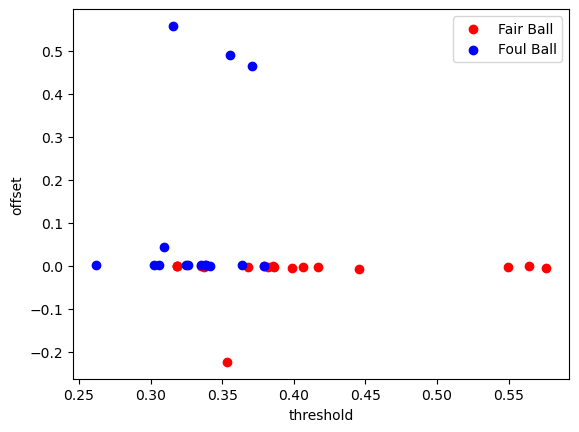

In [12]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "threshold"
ax.scatter(
    outliers[~(outliers["passed"].astype("bool"))][x_val],
    outliers[~(outliers["passed"].astype("bool"))]["offset"],
    color="red",
    label="Fair Ball",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Foul Ball",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

table = outliers
print(len(outliers), "outliers")
print(outliers.groupby(["batting_team_mods"]).size().sort_values())
print(outliers.groupby(["batter_mods"]).size().sort_values())
table[[*digest_list, "baserunner_count"]].sort_values("offset", ascending=False)

## Visualize Threshold

Text(0.5, 0.98, 'All Seasons')

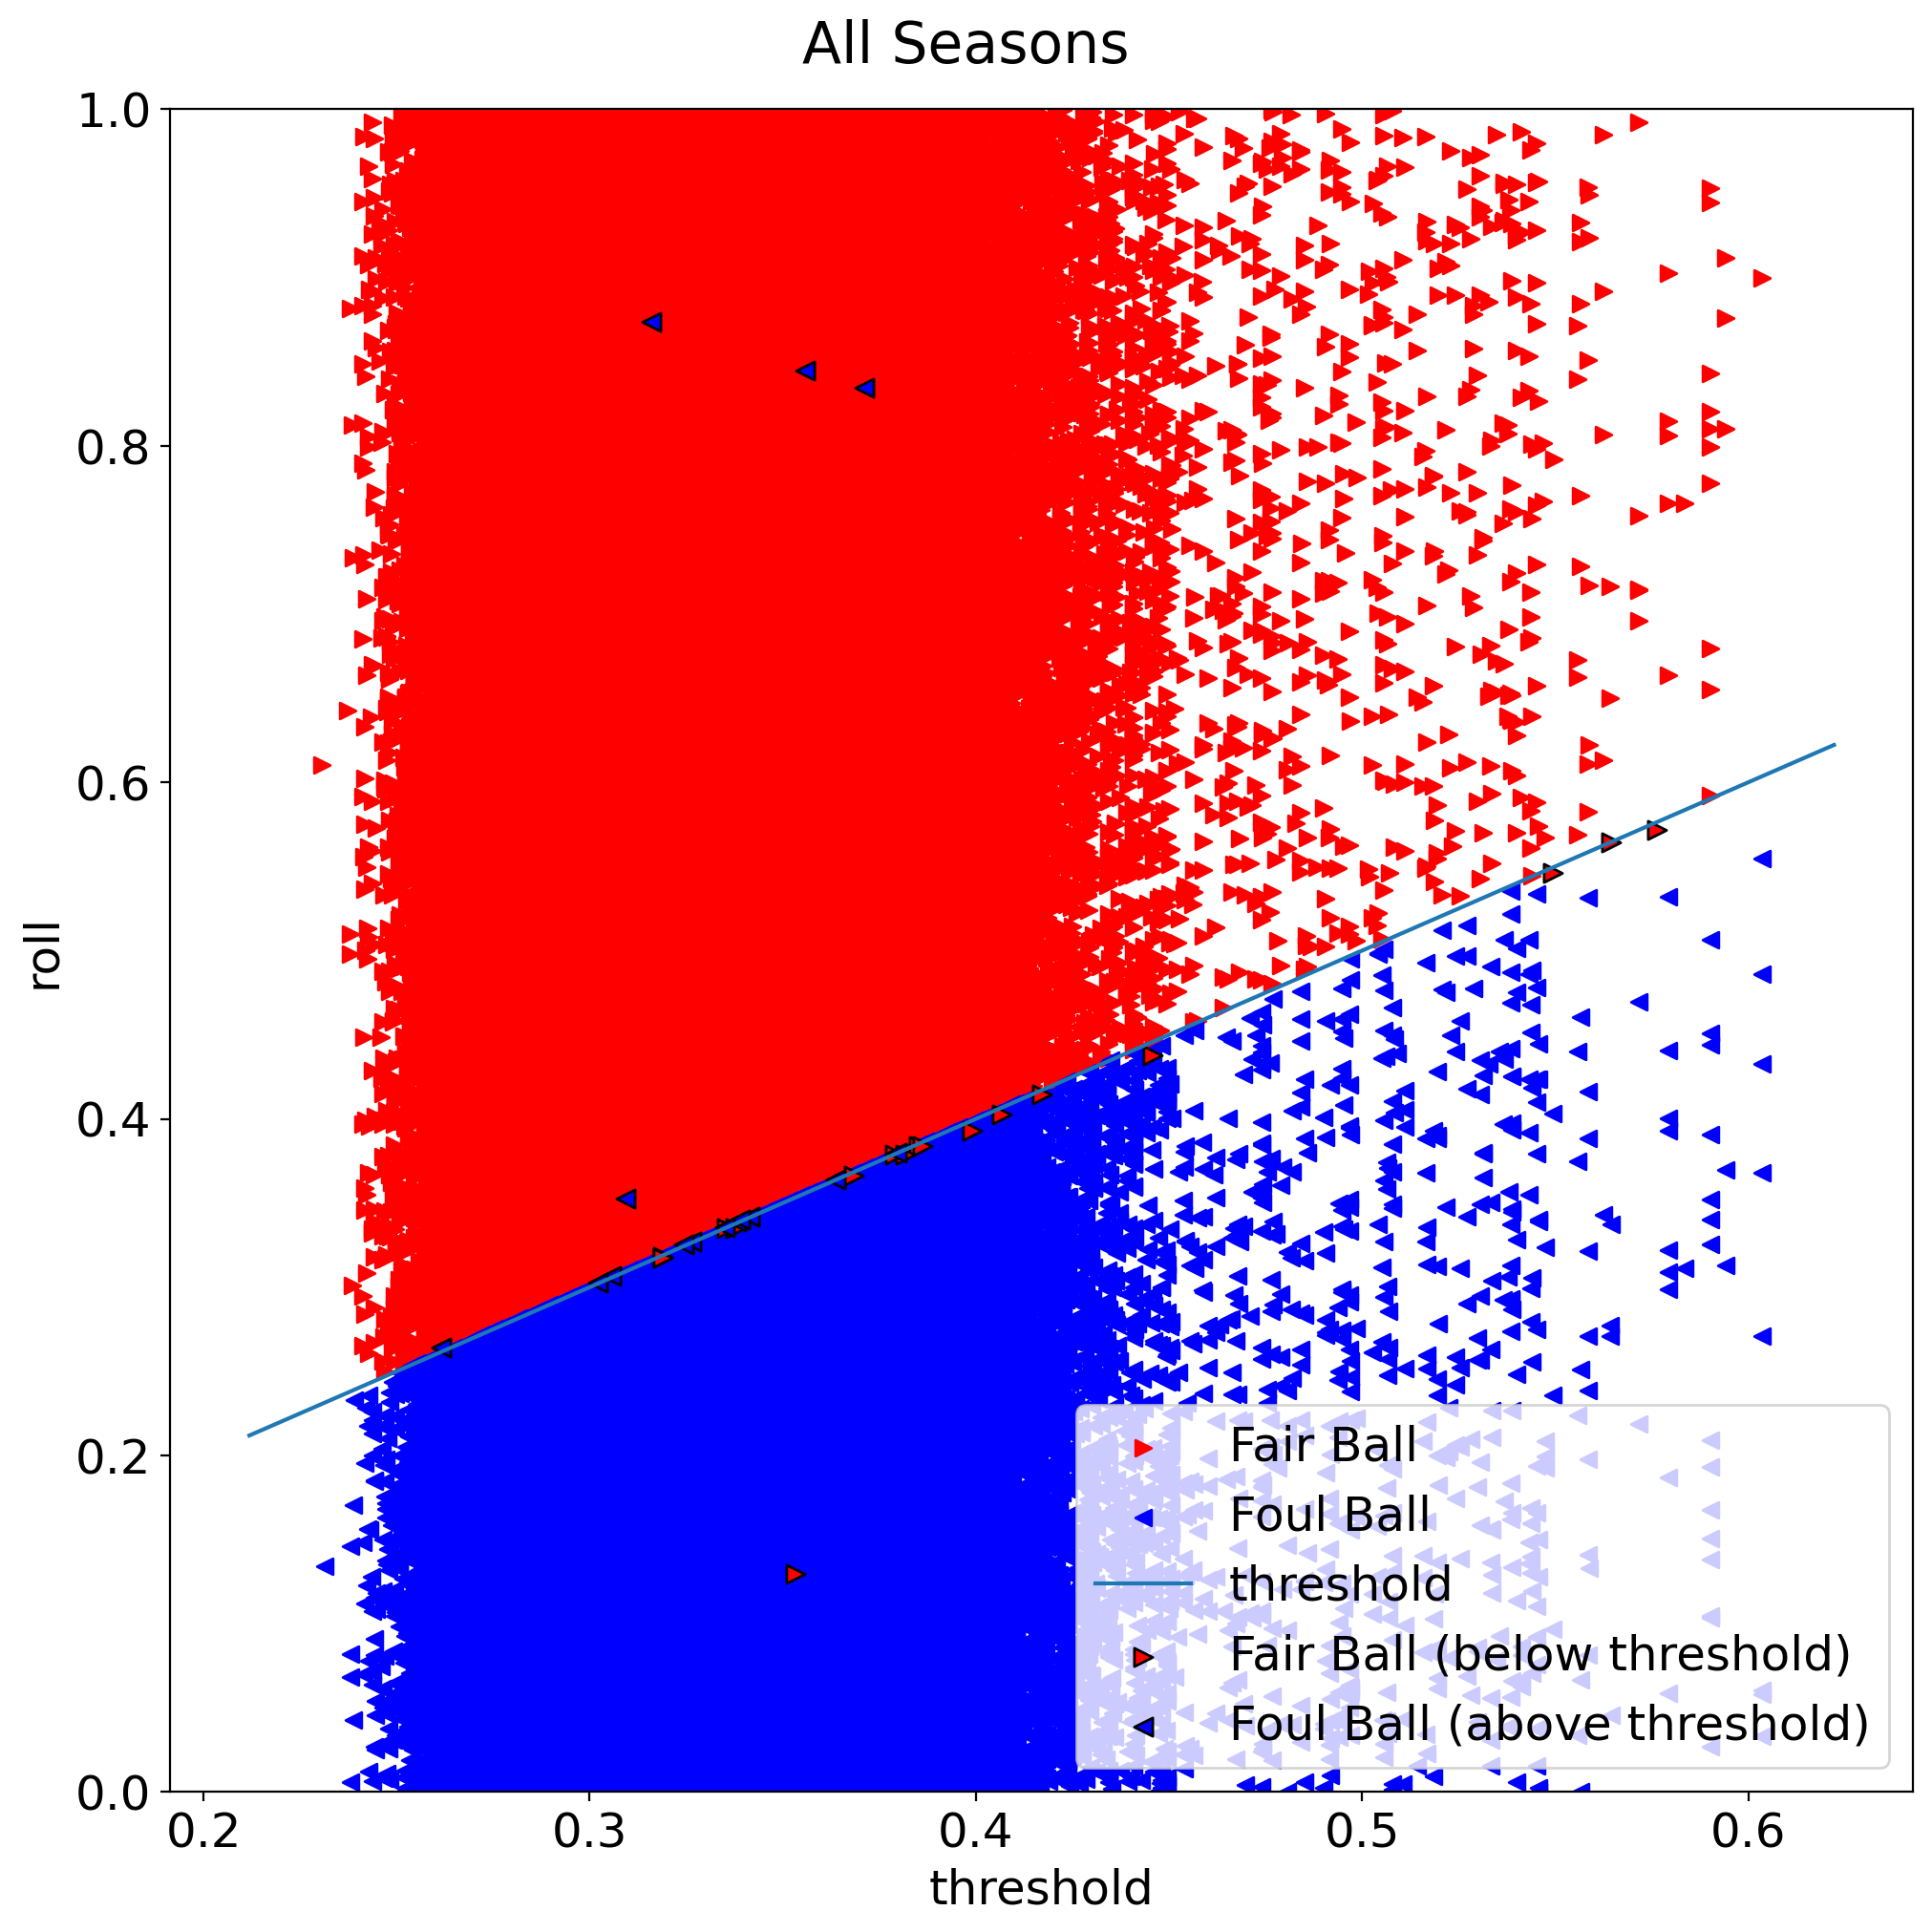

In [13]:
# x_val = "pitcher_ruthlessness"

plt.rcParams["font.size"] = 18
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 10), dpi=200, layout="constrained")

ax.set_ylim(0, 1)
ax.scatter(
    dfc[~(dfc["passed"].astype(bool))][x_val],
    dfc[~(dfc["passed"].astype(bool))]["roll"],
    color="red",
    label="Fair Ball",
    marker=">",
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Foul Ball",
    marker="<",
)
xline = ax.get_xlim()
yline = xline
ax.plot(xline, yline, label="threshold")
if len(outliers) > 0:
    ax.scatter(outliers[~(outliers['passed'].astype(bool))][x_val], outliers[~(outliers['passed'].astype(bool))]["roll"],
               s=48, edgecolor='black', color="red", label="Fair Ball (below threshold)", marker='>')
    ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["roll"],
               s=48, edgecolor='black', color="blue", label="Foul Ball (above threshold)", marker='<')
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
# ax.set_ylim(0.85, 0.86)

ax.legend(loc="lower right")
# fig.suptitle(f"Season {season+1}")
fig.suptitle(f"All Seasons")
# fig.savefig("../figures/strikes_s14_flinch.png", facecolor='white', dpi=200)
# endpoints = np.array(ax.get_xlim())
# ax.plot(endpoints, 0.35 + 0.35 * endpoints)

In [14]:
outliers.groupby("season").size()

season
15    10
16     6
17     5
18    12
dtype: int64

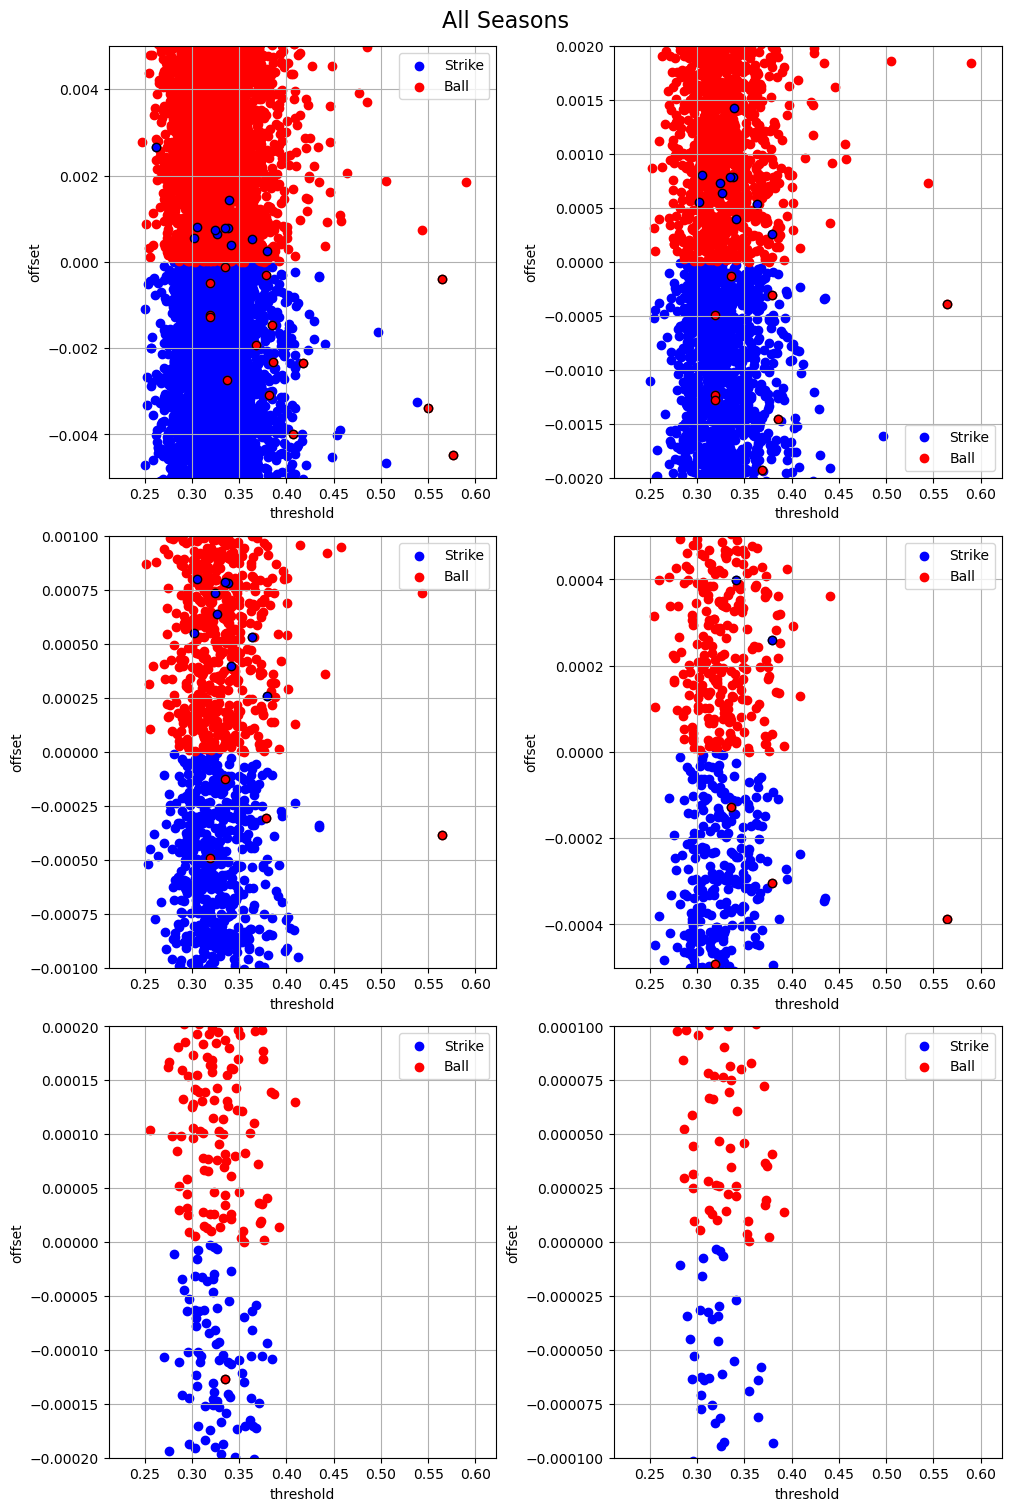

In [15]:
plt.rcParams["font.size"] = 10
x_val = "threshold"
fig, axes = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)
# fig.suptitle(f"Season {season+1}", fontsize=16)
fig.suptitle(f"All Seasons", fontsize=16)
dimlist = [5e-3, 2e-3, 1e-3, 0.5e-3, 0.2e-3, 0.1e-3]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Strike",
    )
    ax.scatter(
        dfc[~(dfc["passed"].astype(bool))][x_val],
        dfc[~(dfc["passed"].astype(bool))]["offset"],
        color="red",
        label="Ball",
    )
    ax.scatter(
        outliers[~(outliers["passed"].astype(bool))][x_val],
        outliers[~(outliers["passed"].astype(bool))]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig("../figures/ball_strike_fit_offsets.png", facecolor='white')